# Demo: compressive Ratio 8:1 

This notebook provides a guide on using a pre-trained model to reconstruct the original images from their compressed versions.

# libs

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import trange, tqdm
from mpl_toolkits.axes_grid1 import make_axes_locatable
import os
import cv2 as cv
import glob
import torch
import torch.nn as nn
from torch.nn import functional as F
import torchvision
import torch.optim as optim
import torchvision
import torchvision.transforms.functional as TF
from torchinfo import summary
from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import structural_similarity as ssim
from NN_module import Upsample, Residual
from utils import (SampleDataset, save_checkpoint, load_checkpoint,
                   get_loaders, check_accuracy, save_predicitons_as_imgs, init_weights)

%matplotlib inline
plt.style.use('default')
plt.rcParams['figure.figsize'] = [8, 8]
plt.rcParams.update({'font.size': 20})
plt.rcParams['figure.dpi'] = 150

# Network architecture

In [3]:
class Decoder(nn.Module):
    def __init__(self, channel, filters=[64, 128, 256, 512]):
        super(Decoder, self).__init__()

        self.input_layer = nn.Sequential(
            nn.Conv2d(channel, filters[0],
                      kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(filters[0]),
            nn.LeakyReLU(),
            nn.Conv2d(filters[0], filters[0],
                      kernel_size=3, padding=1, bias=False),
        )
        self.input_skip = nn.Sequential(
            nn.Conv2d(channel, filters[0],
                      kernel_size=3, padding=1, bias=False)
        )

        self.residual_conv_1 = Residual(
            filters[0], filters[1], use_1x1conv=True)
        self.downsample_1 = nn.Sequential(
            nn.Conv2d(filters[1], filters[1], kernel_size=3,
                      padding=1, stride=2, bias=False),
            nn.BatchNorm2d(filters[1]),
        )

        self.residual_conv_2 = Residual(
            filters[1], filters[2], use_1x1conv=True)
        self.downsample_2 = nn.Sequential(
            nn.Conv2d(filters[2], filters[2], kernel_size=3,
                      padding=1, stride=2, bias=False),
            nn.BatchNorm2d(filters[2]),
        )

        self.bridge = Residual(filters[2], filters[3], use_1x1conv=True)

        self.upsample_1 = Upsample(filters[3], filters[3], 2, 2)
        self.up_residual_conv1 = Residual(
            filters[3] + filters[2], filters[2],
            paddings=1, strides=1, use_1x1conv=True
        )

        self.upsample_2 = Upsample(filters[2], filters[2], 2, 2)
        self.up_residual_conv2 = Residual(
            filters[2] + filters[1], filters[1],
            paddings=1, strides=1, use_1x1conv=True
        )

        self.upsample_3 = Upsample(filters[1], filters[1], 2, 2)
        self.up_residual_conv3 = Residual(
            filters[1], filters[0],
            paddings=1, strides=1, use_1x1conv=True
        )

        self.upsample_4 = Upsample(filters[0], filters[0], 2, 2)
        self.up_residual_conv4 = Residual(
            filters[0], filters[0]//2,
            paddings=1, strides=1, use_1x1conv=True
        )

        self.upsample_5 = Upsample(filters[0]//2, filters[0]//2, 2, 2)
        self.up_residual_conv5 = Residual(
            filters[0]//2, filters[0]//4,
            paddings=1, strides=1, use_1x1conv=True
        )

        self.up_residual_conv6 = Residual(
            filters[0]//4, filters[0]//8,
            paddings=1, strides=1, use_1x1conv=True
        )
        self.up_residual_conv7 = Residual(
            filters[0]//8, filters[0]//16,
            paddings=1, strides=1, use_1x1conv=True
        )
        self.up_residual_conv8 = Residual(
            filters[0]//16, filters[0]//32,
            paddings=1, strides=1, use_1x1conv=True
        )

        self.output_layer = nn.Conv2d(filters[0]//32, 1, 1, 1, bias=True)

    def forward(self, x):
        # Encode
        x1 = self.input_layer(x) + self.input_skip(x)  # 64, 64, 64
        x1 = self.residual_conv_1(x1)  # 128, 64, 64
        x2 = self.downsample_1(x1)  # 128, 32, 32
        x2 = self.residual_conv_2(x2)  # 256, 32, 32
        x3 = self.downsample_2(x2)  # 256, 16, 16

        # Bridge
        x4 = self.bridge(x3)  # 512, 16, 16

        # Decode
        x5 = self.upsample_1(x4)  # 1024, 32, 32
        x5 = torch.cat([x5, x2], dim=1)  # 1536, 32, 32
        x5 = self.up_residual_conv1(x5)  # 512, 32, 32

        x6 = self.upsample_2(x5)  # 512, 64, 64
        x6 = torch.cat([x6, x1], dim=1)  # 768, 64, 64
        x6 = self.up_residual_conv2(x6)  # 256, 64, 64

        x7 = self.upsample_3(x6)  # 256, 128, 128
        x7 = self.up_residual_conv3(x7)  # 128, 128, 128

        x8 = self.upsample_4(x7)  # 128, 256, 256
        x8 = self.up_residual_conv4(x8)  # 64, 256, 256

        x9 = self.upsample_5(x8)  # 64, 512, 512
        x9 = self.up_residual_conv5(x9)  # 32, 512, 512

        # residual blocks
        x10 = self.up_residual_conv6(x9)  # 16, 512, 512
        x11 = self.up_residual_conv7(x10)  # 16, 512, 512
        x12 = self.up_residual_conv8(x11)  # 8, 512, 512

        output = self.output_layer(x12)  # 1, 512, 512

        return output

# Reconstruct images

In [23]:
## show reconstruction and ground truth
## calculate PSNR and SSIM
def comp_rescon_test(model, img_sample, img_true, name):
    x = torch.tensor(img_sample, dtype=torch.float32)
    x = x.unsqueeze(0).to(device='cuda', dtype=torch.float32)
    
    model.eval()
    with torch.no_grad():
        preds = model(x)
        preds = preds.float()
        preds = np.reshape(preds.cpu().detach().numpy(), (512,-1))
    
    img_true = img_true/255.
    
#     preds = np.clip(preds, 0,1)
    preds[np.where(preds>=1)] = 1
    preds[np.where(preds<=0)] = 0
    
    # psnr
    psnr_comparsion = psnr(
        image_true=img_true,
        image_test=preds,
        data_range=1.0
    )
    
    # ssim
    ssim_comparsion = ssim(
        im1=img_true,
        im2=preds,
        data_range=1.0,
        gaussian_weights=True,
        sigma = 1.5,
        use_sample_covariance=False   
    )
    
    
    plt.figure(figsize=(10,20))
    
    plt.subplot(1, 2, 1)
    plt.imshow(preds, cmap='gray')
    plt.axis('off')
    plt.title('prediction')
    
    plt.subplot(1, 2, 2)
    plt.imshow(img_true, cmap='gray')
    plt.title('ground truth')
    plt.axis('off')
    plt.tight_layout()
    plt.show()

    print(f'PSNR={psnr_comparsion :.4f}')
    print(f'SSIM={ssim_comparsion :.4f}')
    
    return preds, img_true, psnr_comparsion, ssim_comparsion

In [41]:
## load a trained model
# the pre-trained model is available on https://drive.google.com/file/d/1KvcER350afkM8qhEHhodct9YYongscCC/view?usp=drive_link
model_64in_8out = Decoder(channel=8).to(device='cuda', dtype=torch.float32)
load_checkpoint(torch.load(
                'my_checkpoint_Decoder_64in8out_real_best.pth.tar'), model_64in_8out)

=> Loading checkpoint


In [34]:
img_name_list = []
for img_path in glob.glob("./data/*.png"):
    img_name_list.append(img_path.split("a/")[1].split(".")[0])
    
img_name_list

['000025_10',
 '000050_10',
 '000030_10',
 '000070_00',
 '000065_00',
 '000035_10',
 '000100_00',
 '000045_00',
 '000021_10',
 '000030_01',
 '000005_10',
 '000060_10',
 '000055_10',
 '000015_00',
 '000050_01',
 '000020_00',
 '000014_10',
 '000035_00',
 '000115_00']

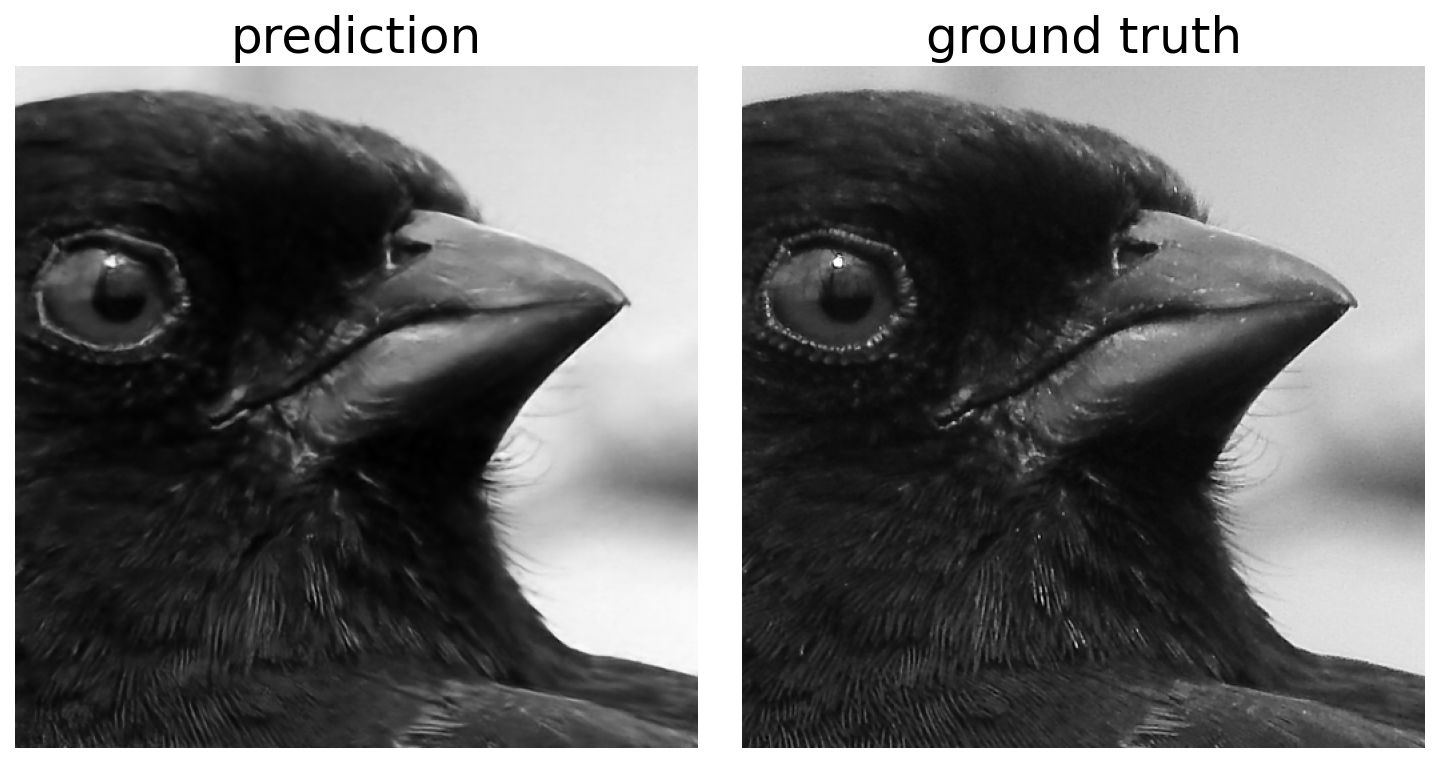

PSNR=33.1680
SSIM=0.9117


In [36]:
## show reconstruction results
name = img_name_list[9]
img_sample = np.load('./data/'+name+'.npy')
img_true = cv.imread('./data/'+name+'.png', 0).astype(np.float32)
img_sample = np.abs(img_sample.transpose((2,0,1)))
preds, img_true, psnr_comparsion, ssim_comparsion = comp_rescon_test(model_64in_8out, img_sample, img_true, name)